In this notebook, we will first aggregate data on an hourly basis to be used for predictive analysis. Then, we will engineer new features for the model. Finally, we will do feature selection and drop some features to reduce dimensionality.

## Data Aggregation
First, let us aggregate data on an hourly basis to be used for predictive analysis.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
trips_df = pd.read_pickle('../00_data/trips.pkl')

In [13]:
# floor start and end times of trips to hour value, i.e. ignore minutes and seconds
trips_df['start_time_floored'] = trips_df['start_time'].dt.floor('1H')
trips_df['end_time_floored'] = trips_df['end_time'].dt.floor('1H')

In [14]:
# calculate the number of starting and ending trips for each hour
starting_trips_grouped = (
    trips_df.groupby(["start_time_floored"])
    .size()
    .to_frame("starting_trips")
)
ending_trips_grouped = (
    trips_df.groupby(["end_time_floored"])
    .size()
    .to_frame("ending_trips")
)

In [15]:
# combine these values into a single dataframe and determine whether data cleaning is necessary
trips_hourly = pd.concat([starting_trips_grouped, ending_trips_grouped], axis=1)
trips_hourly.isna().sum()

starting_trips    142
ending_trips       85
dtype: int64

There are some missing values, because there may be hours at which trips start but no trips end and vice versa. We will fill these null values with 0, which represents 0 trips started/ended in this hour, and save this aggregated data into a new file.

In [16]:
trips_hourly = trips_hourly.fillna(0) 

In [17]:
trips_hourly.to_pickle('../00_data/trips_hourly.pkl')

## Feature Engineering
Now we will combine different data collected until now into a single dataframe and additionally calculate some new features. This data will be then be used as features for predictive analysis.

In [18]:
import pandas as pd

In [19]:
trips_hourly = pd.read_pickle('../00_data/trips_hourly.pkl')
trips_df = pd.read_pickle('../00_data/trips.pkl')

### Create ```available_bikes``` feature
We assume that one of the features influencing the demand is the number of bicycles available for rental. If the user opens the app and sees only a few or even no bikes in the stations near them, they will most likely choose an alternative mode of transport.

In order to calculate ```available_bikes``` we first have to determine how many bikes there are in the fleet and how many bikes are being currently rented. We will start with the second one, which we defined as the cumulative sum of the difference between started and ended trips. We then use the number of ongoing trips from the previous hour as an input feature.

In [20]:
trips_hourly['trips_diff'] = trips_hourly['starting_trips'] - trips_hourly['ending_trips']
trips_hourly['ongoing_trips'] = trips_hourly['trips_diff'].cumsum()

# save values from the previous hour in an additional column
trips_hourly['ongoing_trips_prev'] = trips_hourly['ongoing_trips'].shift(1)

# keep only the columns of interest; here starting trips represents demand
trips_hourly = trips_hourly[['starting_trips', 'ongoing_trips_prev']]

In [21]:
trips_hourly.head(4)

,starting_trips,ongoing_trips_prev
2019-01-01 00:00:00,14.0,NaN
2019-01-01 01:00:00,8.0,2.0
2019-01-01 02:00:00,11.0,4.0
2019-01-01 03:00:00,2.0,3.0


In [22]:
# effectively drops first observation as ongoing trips prev cannot be calculated due to the absence of data
trips_hourly = trips_hourly.dropna()

Next, we aim to determine the number of bicycles in the fleet. The easiest way would be to sum the number of unique bike ids. However, this calculation would most likely overestimate the actual value. We assume that bikes regularly break and have to be repaired, and therefore are unavailable to customers. Also, Metro Bike Share might want to control the fleet size to respond to changes in demand during different seasons. Therefore, we decided to calculate the number of unique bicycle ids for each week. Hereby, we assume that each bicycle, that is not broken and is placed correctly is used at least once a week.

In [23]:
trips_df['week'] = trips_df['start_time'].dt.isocalendar().week

bike_ids_week_grouped = (
    trips_df.groupby(["week"])['bike_id']
    .nunique()
    .to_frame("bike_ids_week")
)
print(f"There are in total {trips_df['bike_id'].nunique()} unique bike ids in the whole dataset.")
print(f"On average there are {bike_ids_week_grouped['bike_ids_week'].mean()} bikes available.")

There are in total 3893 unique bike ids in the whole dataset.
On average there are 757.3461538461538 bikes available.


As we see, there is a substantial difference between the two numbers. In order to identify which one is more realistic, we will do some further analysis.

In [24]:
# create dataframe that depicts the first time and the last time each bicycle was used (in our defined timeframe)
# and the number of trips made with it
bikes_df = trips_df.groupby("bike_id").agg(
    {
		"start_time": "min",
		"end_time": "max",
		"bike_id": "count"
	}
)
bikes_df = bikes_df.rename(columns={
    "start_time" : "first_trip_start_time",
    "end_time" : "last_trip_end_time",
    "bike_id" : "number_of_trips"
})
bikes_df.head(2)

,first_trip_start_time,last_trip_end_time,number_of_trips
bike_id,,,
5715,2019-04-17 23:39:00,2019-12-17 21:57:12,68
5716,2019-04-13 15:58:00,2019-06-07 17:13:00,33


In [25]:
# show bike(s) with the latest start time
trips_df[(trips_df["bike_id"] == bikes_df["first_trip_start_time"].idxmax())]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,...,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end,week
222737,2019-12-31 20:50:25,2019-12-31 20:58:42,4442,4436,6130,Annual Pass,Normandie & Sunset,Vermont & Franklin,0 days 00:08:17,34.098,...,19,1,1,0,51,15,1,2,0,1


In [26]:
# show bike(s) with the earliest end time
trips_df[(trips_df["bike_id"] == bikes_df["last_trip_end_time"].idxmin())]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,...,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end,week
218790,2019-01-01 11:07:00,2019-01-01 11:49:00,4210,4210,12043,Walk-up,Ocean Front Walk & North Venice,Ocean Front Walk & North Venice,0 days 00:42:00,33.98434,...,5,0,0,0,13,5,0,0,0,1
218798,2019-01-01 12:29:00,2019-01-01 12:52:00,4210,4210,12043,Walk-up,Ocean Front Walk & North Venice,Ocean Front Walk & North Venice,0 days 00:23:00,33.98434,...,5,0,0,0,13,5,0,0,0,1


There is a bike that was used on 31.12.2019 (the last day of our timeframe) for the first time and two bikes that were used on 01.01.2019 (the first day of our timeframe) for the last time. Clearly, none of these three bikes were available throughout the whole year. This proves that considering some sort of average is more accurate than a bold sum of all unique bike ids.

We already have the time when each bicycle was used for the first and last time. Now we will aggregate the dataframe by these hours and calculate how many bicycle were used after and before certain hours. Afterwards, we will calculate the cumulative sum of the difference between ```bikes_used_after``` and ```bikes_used_before``` for each hour. Thus, we receive the new column ```in_service_bikes```.

In [27]:
bikes_df["start_time_floored"] = bikes_df["first_trip_start_time"].dt.floor("1H")
bikes_df["end_time_floored"] = bikes_df["last_trip_end_time"].dt.floor("1H") + pd.DateOffset(hours=1)

bikes_used_after = (
    bikes_df.groupby("start_time_floored").size().to_frame("bikes_used_after")
)
bikes_used_before = (
    bikes_df.groupby("end_time_floored").size().to_frame("bikes_used_before")
)

bikes_used = pd.concat([bikes_used_before, bikes_used_after], axis=1)
bikes_used = bikes_used.fillna(0)
bikes_used['diff'] = bikes_used['bikes_used_after'] - bikes_used['bikes_used_before'] 
bikes_used['in_service_bikes'] = bikes_used['diff'].cumsum()


Text(0, 0.5, 'Number of bikes in service')

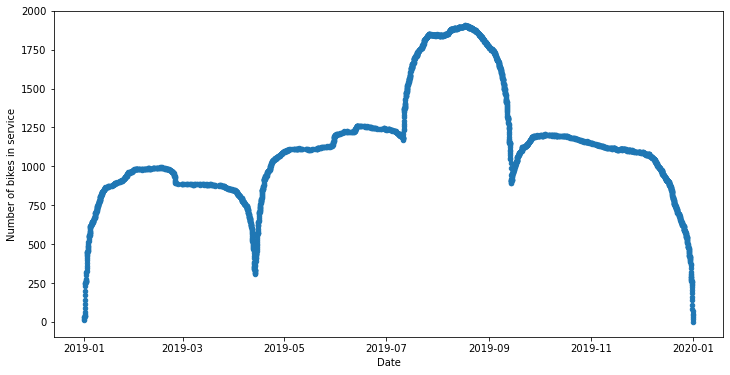

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
# plot 'in_service_bikes' over time
bikes_used = bikes_used.reset_index().rename(columns={"index": "start_time_floored"})
bikes_used.plot.scatter(x="start_time_floored", y="in_service_bikes", ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Number of bikes in service')


In [29]:
# to smooth out the edges, especially at the beginning and the end of the dataset, we introduce in_service_bikes_rolling
# rolling function provides us with a maximum value of 'in_service_bikes' column during a 30 days window
bikes_used["in_service_bikes_rolling"] = bikes_used.rolling(
    "30d", center=True, on="start_time_floored"
)["in_service_bikes"].max()


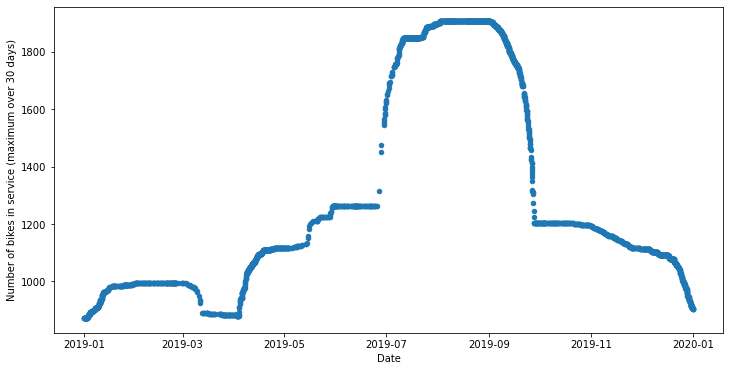

In [30]:
# plot 'in_service_bikes_rolling' over time with matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
bikes_used.plot.scatter(x="start_time_floored", y="in_service_bikes_rolling", ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Number of bikes in service (maximum over 30 days)')

fig.savefig('../figures/bikes_in_service_rolling.png')

In [31]:
bikes_used = bikes_used.set_index("start_time_floored")

In [32]:
# fill null values
trips_hourly['in_service_bikes_rolling'] = bikes_used['in_service_bikes_rolling'].asfreq('1H', method="bfill")
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling
2019-01-01 01:00:00,8.0,2.0,873.0
2019-01-01 02:00:00,11.0,4.0,873.0


In [33]:
# compute the 'available_bikes'
trips_hourly["available_bikes"] = (
    trips_hourly["in_service_bikes_rolling"] - trips_hourly["ongoing_trips_prev"]
)
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes
2019-01-01 01:00:00,8.0,2.0,873.0,871.0
2019-01-01 02:00:00,11.0,4.0,873.0,869.0


In [34]:
trips_hourly.describe()

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes
count,8423.000000,8423.000000,8423.000000,8423.000000
mean,26.787012,10.834145,1273.804464,1262.970319
std,21.222319,10.956030,341.333060,340.324112
min,0.000000,0.000000,873.000000,825.000000
25%,7.000000,5.000000,993.000000,988.000000
50%,25.000000,9.000000,1160.000000,1151.000000
75%,41.000000,14.000000,1451.000000,1443.500000
max,281.000000,364.000000,1905.000000,1904.000000


### Add weather features
Copy precipitation, min and max temperature values from weather dataset.

In [35]:
weather_df = pd.read_pickle('../00_data/weather.pkl')

In [36]:
trips_hourly['max_temp'] = weather_df['max_temp']
trips_hourly['min_temp'] = weather_df['min_temp']
trips_hourly['precip'] = weather_df['precip']

In [37]:
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes,max_temp,min_temp,precip
2019-01-01 01:00:00,8.0,2.0,873.0,871.0,15.6,15.6,0.0
2019-01-01 02:00:00,11.0,4.0,873.0,869.0,15.0,15.0,0.0


In [38]:
trips_hourly = trips_hourly.dropna()

### Create time related features

In [39]:
trips_hourly['hour'] = trips_hourly.index.hour
trips_hourly['day_of_week'] = trips_hourly.index.day_of_week
trips_hourly['month'] = trips_hourly.index.month
trips_hourly['day_of_year'] = trips_hourly.index.day_of_year
trips_hourly['week'] = trips_hourly.index.isocalendar().week.astype('int64')
trips_hourly['is_weekday'] = trips_hourly['day_of_week'] < 5
trips_hourly['date'] = trips_hourly.index.date.astype('datetime64[ns]')

In [40]:
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date
2019-01-01 01:00:00,8.0,2.0,873.0,871.0,15.6,15.6,0.0,1,1,1,1,1,True,2019-01-01
2019-01-01 02:00:00,11.0,4.0,873.0,869.0,15.0,15.0,0.0,2,1,1,1,1,True,2019-01-01


### Create is holiday feature
We create a feature 'is_holiday', which is true when there is an entry on the same day in the holidays' dataset, and false otherwise.

In [41]:
holidays_df = pd.read_pickle('../00_data/holidays.pkl')

In [42]:
trips_hourly = trips_hourly.reset_index().merge(holidays_df, on='date', how='left').set_index('index')

In [43]:
trips_hourly['is_holiday'] = trips_hourly['holiday_name'].notna()
trips_hourly = trips_hourly.drop(columns=['holiday_name', 'date'])
trips_hourly.columns

Index(['starting_trips', 'ongoing_trips_prev', 'in_service_bikes_rolling',
       'available_bikes', 'max_temp', 'min_temp', 'precip', 'hour',
       'day_of_week', 'month', 'day_of_year', 'week', 'is_weekday',
       'is_holiday'],
      dtype='object')

In [44]:
trips_hourly.to_pickle('../00_data/trips_hourly_engineered.pkl')

## Feature Selection
Now we will filter previously prepared features. This will be done, firstly, based on the correlation of independent features and secondly, based on the results of Lasso Regression.

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [46]:
trips_hourly_df = pd.read_pickle("../00_data/trips_hourly_engineered.pkl")
trips_hourly_df.columns

Index(['starting_trips', 'ongoing_trips_prev', 'in_service_bikes_rolling',
       'available_bikes', 'max_temp', 'min_temp', 'precip', 'hour',
       'day_of_week', 'month', 'day_of_year', 'week', 'is_weekday',
       'is_holiday'],
      dtype='object')

### Feature Correlation
We will now compute the correlation coefficient of each pair of features. Then we will retain only one of two features if their correlation coefficient is above 0.7 (or 70%). This is done because with highly correlated features one can be predicted from another. The second feature does not add any additional information to the model this way.

In [47]:
trips_hourly_df.corr()

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,is_holiday
starting_trips,1.000000,0.569527,0.141622,0.123436,0.035981,0.033918,-0.057172,0.390460,-0.126312,0.124065,0.125217,0.126346,0.174406,-0.063861
ongoing_trips_prev,0.569527,1.000000,0.100954,0.068613,0.039249,0.038683,-0.048383,0.265459,0.075420,0.004065,0.002999,0.003419,-0.067057,-0.024483
in_service_bikes_rolling,0.141622,0.100954,1.000000,0.999473,0.586802,0.585854,-0.109778,-0.010288,0.004747,0.359183,0.356008,0.377125,-0.002675,-0.063135
available_bikes,0.123436,0.068613,0.999473,1.000000,0.587145,0.586213,-0.108504,-0.018975,0.002300,0.360044,0.356895,0.378057,-0.000495,-0.062511
max_temp,0.035981,0.039249,0.586802,0.587145,1.000000,0.999440,-0.146816,0.179775,0.017991,0.400793,0.401090,0.412108,-0.027452,-0.049952
min_temp,0.033918,0.038683,0.585854,0.586213,0.999440,1.000000,-0.150187,0.178030,0.019351,0.400901,0.401268,0.412107,-0.029415,-0.049908
precip,-0.057172,-0.048383,-0.109778,-0.108504,-0.146816,-0.150187,1.000000,0.024321,-0.015739,-0.098087,-0.100351,-0.096719,0.009660,0.071312
hour,0.390460,0.265459,-0.010288,-0.018975,0.179775,0.178030,0.024321,1.000000,-0.007612,-0.006197,-0.006243,-0.005902,0.005013,0.002796
day_of_week,-0.126312,0.075420,0.004747,0.002300,0.017991,0.019351,-0.015739,-0.007612,1.000000,-0.001364,-0.000885,0.005483,-0.791667,-0.091905
month,0.124065,0.004065,0.359183,0.360044,0.400793,0.400901,-0.098087,-0.006197,-0.001364,1.000000,0.996513,0.964648,-0.007627,0.014925


The table provides all information at glance. However, it is difficult to single out pairs of features that are of interest to us. Therefore, we will write an additional method to print only those with their corresponding correlation coefficient.

In [48]:
for id_1, variable in enumerate(trips_hourly_df.columns):
    for id_2, comp_variable in enumerate(trips_hourly_df.columns):
        if id_1 < id_2:
            corrcoeff = np.corrcoef(
                [
                    trips_hourly_df[variable].astype("float64"),
                    trips_hourly_df[comp_variable].astype("float64"),
                ]
            )[0][1]
            if corrcoeff > 0.7:
                print(variable, comp_variable, corrcoeff)
                

in_service_bikes_rolling available_bikes 0.9994732618754624
max_temp min_temp 0.9994397326220161
month day_of_year 0.9965133987634793
month week 0.9646476104189302
day_of_year week 0.9653615873661971


In general, it doesn't matter which feature to drop from each pair. We decided to exclude the following - ```in_service_bikes_rolling, max_temp, day_of_year, week```.

In [49]:
trips_hourly_df = trips_hourly_df.drop(
    columns=["in_service_bikes_rolling", "max_temp", "day_of_year", "week"]
)
trips_hourly_df.head(2)

,starting_trips,ongoing_trips_prev,available_bikes,min_temp,precip,hour,day_of_week,month,is_weekday,is_holiday
index,,,,,,,,,,
2019-01-01 01:00:00,8.0,2.0,871.0,15.6,0.0,1,1,1,True,True
2019-01-01 02:00:00,11.0,4.0,869.0,15.0,0.0,2,1,1,True,True


### Lasso Regression
Here, we will compute a simple linear regression. Lasso Regression is often used for feature selection because it assigns 0 coefficient to features with a very low impact on the predicted variable. These features can then be excluded from future analysis.

In [50]:
input_features = trips_hourly_df.reset_index().drop(columns=["starting_trips", "index"])
predicted_varible = trips_hourly_df["starting_trips"]

In [51]:
# scale input features
scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features.values)

In [52]:
# fit data to the linear regression model
model = Lasso(alpha=1)
model.fit(input_features_scaled, predicted_varible)
print("Coefficients ", model.coef_)

Coefficients  [10.02267528  0.72193158 -0.47767462 -0.          4.72310471 -0.
  1.58323662  3.35491256 -0.20255563]


The results of the Lasso regression yield 0 coefficient for features precipitation, is_weekday, and is_holiday. Therefore we will drop these for the predictive analytics section.

In [53]:
trips_hourly_df = trips_hourly_df.drop(columns={"precip", "day_of_week"})

In [54]:
trips_hourly_df.to_pickle("../00_data/trips_hourly_selected.pkl")